In [1]:
import sys

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.8.19 (default, Mar 20 2024, 15:27:52) 
[Clang 14.0.6 ]
Version info.
sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)


In [42]:
import datetime
import nbformat

def save_checkpoint(notebook_name):
    checkpoint_dir = "./checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Load current notebook
    with open(f"./{notebook_name}") as f:
        nb = nbformat.read(f, as_version=4)

    # Create a checkpoint filename with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_name = f"{os.path.basename(notebook_name).replace('.ipynb', '')}_checkpoint_{timestamp}.ipynb"

    # Save the checkpoint
    with open(f"{checkpoint_dir}/{checkpoint_name}", 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)

    print(f"Checkpoint saved as {checkpoint_name}")
    return checkpoint_name

def load_checkpoint(checkpoint_name):
    """
    Load a checkpointed notebook and display its contents in the current Jupyter environment.
    """
    with open(f"./checkpoints/{checkpoint_name}", 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
    return nb

# Plate2Recipe NLP Model: 
Recipe Generation from Ingredients List using GPT-2 and TF-IDF Similarity Matching

@Author: Nellie Cordova

### NLP Model
- Assume list of ingredients is provided, use this to generate the recipe. 
- Match input list of ingredients with the ingredients in the dataset and generate the recipe
- Approach:
        -- TF-IDF: Vectorization of ingredients.
        -- Cosine Similarity: to find the recipe in the dataset that has the highest similarity to the provided ingredients.
        -- GPT2 model: Generate the recipe based on the matched recipe.

In [3]:
import os
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Using cached bayesian_optimization-1.4.3-py3-none-any.whl.metadata (543 bytes)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached bayesian_optimization-1.4.3-py3-none-any.whl (18 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)


### Data Collection and Preprocessing

- Data loading: *use full_dataset.csv for NLP* (https://drive.google.com/drive/folders/1ui_zS11_ENZTCNLUsgg_UwAYr-ZaLbac)
- Data cleaning
- Data augmentation

In [4]:
# MPS memory management - Used to solve RuntimeError: MPS backend out of memory
# source: https://pnote.eu/notes/pytorch-mac-setup/
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# Check that the environment variable is set correctly
print("PYTORCH_MPS_HIGH_WATERMARK_RATIO set to:", os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'])

PYTORCH_MPS_HIGH_WATERMARK_RATIO set to: 0.0


In [5]:
# Set device to maximize performance

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
device = torch.device(device)

In [6]:
print(device)

mps


In [7]:
# Helper function to clear unused memory
def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

In [8]:
clear_memory()

In [9]:
user_ingredients = ['avocado', 'rice', 'shrimp', 'tomato']
dataset_path = './data/full_dataset.csv'
pickle_path = './data/recipes.pickle'

n_recipes = 100
model_path = "gpt2"
best_model_path = f'./models/best_gpt2_model_{n_recipes}'

In [11]:
# Load the dataset
def load_data(filepath):
    data = pd.read_csv(filepath).drop(['Unnamed: 0'], axis=1)
    return data

recipes = load_data(dataset_path)

In [ ]:
from utils.data_utils import save_pickle, load_pickle
save_pickle(recipes, pickle_path)
dat = load_pickle(pickle_path)

In [12]:
# Set a seed for reproducibility
random.seed(42)

# Shuffle the DataFrame
recipes_shuffled = recipes.sample(frac=1).reset_index(drop=True)

# Select 50% of the recipes randomly
num_recipes_to_keep = n_recipes #int(len(recipes_shuffled) * 0.5)
recipes = recipes_shuffled[:num_recipes_to_keep]

# Print the new DataFrame
recipes.head(5)

,title,ingredients,directions,link,source,NER
0,Crisp Rosemary-Parmesan Garlic Bread,"[""2 tablespoons butter, room temperature"", ""2 ...","[""Blend butter and rosemary in processor."", ""G...",www.food.com/recipe/crisp-rosemary-parmesan-ga...,Gathered,"[""butter"", ""fresh rosemary"", ""extra virgin oli..."
1,"Bean and Vegetable Soup, First Time Around","[""1/4 cup extra virgin olive oil"", ""4 slices b...","[""Heat olive oil and bacon and cook until baco...",www.foodnetwork.com/recipes/bean-and-vegetable...,Recipes1M,"[""extra virgin olive oil"", ""bacon"", ""onions"", ..."
2,Persimmon Pudding,"[""1 stick margarine"", ""2 c. persimmon"", ""2 c. ...","[""Mix all ingredients thoroughly."", ""Bake at 3...",www.cookbooks.com/Recipe-Details.aspx?id=678569,Gathered,"[""margarine"", ""persimmon"", ""flour"", ""eggs"", ""s..."
3,Courgette Chocolate Cake,"[""125 g butter"", ""1 cup brown sugar"", ""1/2 cup...","[""Prepare 25cm square cake tin by lining with ...",www.food.com/recipe/courgette-chocolate-cake-3...,Gathered,"[""butter"", ""brown sugar"", ""white sugar"", ""eggs..."
4,Sausage Gravy,"[""1/2 lb. bulk sausage"", ""2 Tbsp. flour"", ""1 1...","[""Scramble sausage in heavy saucepan."", ""When ...",www.cookbooks.com/Recipe-Details.aspx?id=640864,Gathered,"[""bulk sausage"", ""flour"", ""milk"", ""salt"", ""ref..."


In [13]:
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        100 non-null    object
 1   ingredients  100 non-null    object
 2   directions   100 non-null    object
 3   link         100 non-null    object
 4   source       100 non-null    object
 5   NER          100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB
None


#### Tokenize, compute TF-IDF and prepare the similarity measure

In [14]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path, padding_side='left')
    return model, tokenizer

In [15]:
def prepare_similarity_matrix(recipes):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(recipes['NER'])
    return tfidf_vectorizer, tfidf_matrix

tfidf_vectorizer, tfidf_matrix = prepare_similarity_matrix(recipes)

In [16]:
import ast

def find_best_match(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix):
    """Calculate cosine similarity and return the best recipe match."""
    user_input_tfidf = tfidf_vectorizer.transform([' '.join(user_ingredients)])
    cos_similarities = cosine_similarity(user_input_tfidf, tfidf_matrix)
    best_recipe_index = cos_similarities.argmax()
    return recipes.iloc[best_recipe_index]

def remove_repetitions(text):
    """Helper function to remove repeated sentences in a list of directions."""
    seen = set()
    result = []
    for item in text:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

def generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, model, tokenizer):
    # Find the recipe that matches the user ingredients
    best_recipe = find_best_match(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix)

    # Parse ingredients and directions from the dataframe
    ingredients_list = ast.literal_eval(best_recipe['ingredients'])
    directions_list = ast.literal_eval(best_recipe['directions'])

    # Reformat input to the model
    ingredients_text = "Ingredients:\n" + "\n".join([f"- {ingredient}" for ingredient in ingredients_list])
    directions_text = "Directions:\n" + "\n".join([f"Step {i+1}: {step}" for i, step in enumerate(directions_list)])
    prompt_text = f"Recipe Title: {best_recipe['title']}\n\n{ingredients_text}\n\n{directions_text}"

    # Generate the recipe text
    encoded = tokenizer.encode_plus(prompt_text, return_tensors="pt", padding='max_length', truncation=True)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    pad_token_id = tokenizer.pad_token_id
    outputs = model.generate(input_ids, attention_mask=attention_mask, pad_token_id=pad_token_id, max_length=1024 + 50, num_return_sequences=1, no_repeat_ngram_size=2)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove repetitions in the generated text
    final_text_lines = generated_text.split('\n')
    final_text_lines = remove_repetitions(final_text_lines)

    return "\n".join(final_text_lines)

- Prepare data for training the GPT-2 model.
- DataLoader creation for training and validation sets.
- Model Training & Validation methods

In [17]:
class RecipeDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'labels': encoded['input_ids'].flatten()  # Labels for language modeling
        }


def create_data_loaders(recipes, batch_size, tokenizer, max_length):
    # Combine title, ingredients, and directions into a single text input for each recipe
    combined_texts = recipes.apply(lambda row: f"Recipe Title: {row['title']} Ingredients: {row['ingredients']} Directions: {row['directions']}", axis=1)
    
    # Split data into training and validation sets
    train_texts, val_texts = train_test_split(combined_texts, test_size=0.2, random_state=42)

    # Create Dataset objects
    train_dataset = RecipeDataset(train_texts.tolist(), tokenizer, max_length)
    val_dataset = RecipeDataset(val_texts.tolist(), tokenizer, max_length)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [60]:
def train_and_validate(model, device, train_loader, val_loader, best_params=None):
    print("Training optimized model...")

    if best_params is None:
        best_params = {}
    
    num_train_epochs = int(best_params.get('num_train_epochs', 10))
    learning_rate = best_params.get('learning_rate', 1e-5)
    weight_decay = best_params.get('weight_decay', 0)  # Default 0 if not specified
    warmup_steps = int(best_params.get('warmup_steps', 0))  # Default 0 if not specified

    # Set up the optimizer and scheduler using the best learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    
    # Use gradient accumulation to handle memory limits
    accumulation_steps = 4  # Adjust based on specific memory constraints


    # Lists to store per-epoch metrics
    training_losses = []
    validation_losses = []
    training_perplexities = []
    validation_perplexities = []
    best_val_loss = float('inf')


    # Training loop
    model.train()
    for epoch in range(num_train_epochs):
        total_loss = 0
        model.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize the loss to account for accumulation
            
            loss.backward()
            total_loss += loss.item()
            
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                model.zero_grad()

            # loss.backward()
            # optimizer.step()
            # scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_ppl = torch.exp(torch.tensor(avg_train_loss)).item()
        training_losses.append(avg_train_loss)
        training_perplexities.append(train_ppl)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_ppl = torch.exp(torch.tensor(avg_val_loss)).item()
        validation_losses.append(avg_val_loss)
        validation_perplexities.append(val_ppl)

        print(f"Epoch {epoch + 1}/{num_train_epochs} | Train Loss: {avg_train_loss:.3f} | Train PPL: {train_ppl:.3f} | Val Loss: {avg_val_loss:.3f} | Val PPL: {val_ppl:.3f}")
        
        # Save the best model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model at {best_model_path}")
            
        # Clear memory at the end of each epoch
        clear_memory()
    
    print(f"Saved new best model at {best_model_path}")
    
    return training_losses, validation_losses, training_perplexities, validation_perplexities, model

In [61]:
import matplotlib.pyplot as plt

def plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities):
    epochs = range(1, len(training_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_perplexities, 'bo-', label='Training Perplexity')
    plt.plot(epochs, validation_perplexities, 'ro-', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model optimization with Bayesian Optimization: 
This approach combines traditional NLP techniques for ingredient matching with advanced language generation capabilities of GPT-2

- Prepare data for fine-tuning: tokenize and format the data suitable for GPT-2
- Hyperparameter Tuning: Explore different learning rates, batch sizes, and number of epochs
    - Bayesian Optimization uses a probabilistic model to guide the search for the best hyperparameters. It balances exploration and exploitation to find the optimal hyperparameters efficiently. 

- Training: Train the model with recipes data, monitoring for convergence and performance.
- Evaluation: Evaluate the model using validation data and metrics like perplexity.
- Visualization of Results: Use plots to show training losses and evaluation metrics.

### Hyperparameter Tuning

Optimizer Selection
- Adam is a popular choice due to its effectiveness in handling sparse gradients and adaptive learning rate techniques.

Learning Rates
- Initial Value: Starting learning rate in the range of 2e-5 to 5e-5, which are common starting points for fine-tuning language models.
- Decay Strategy: Reduce the learning rate gradually as training progresses. This helps in fine-tuning the model to achieve better performance as it converges.
- Warm-up Steps: Implementing a warm-up period for the learning rate can help stabilize the model's training early in the process, gradually increasing the learning rate from zero to the initial set learning rate.

Batch Sizes
- Size Range: Experiment with batch sizes, starting from smaller batches like 4 or 8, up to larger batches if your hardware supports it (e.g., 16, 32). Larger batch sizes provide a more stable gradient, but they require more memory.
- Gradient Accumulation: If memory limits batch size, used to simulate larger batches. This means updating model weights less frequently, accumulating gradients over multiple forward passes.

Number of Epochs
- Epoch Count: Number of epochs is increased based on the initial results and if the model has not started overfitting. (See how quickly the model learns)
- Early Stopping: Halt training when the validation metric (like perplexity or validation loss) stops improving. This prevents overfitting and saves computational resources.

Weight Decay 
- (L2 Regularization): Prevents overfitting by penalizing large weights. Helps maintain a balance between model complexity and dataset simplicity.

Gradient Clipping: 
- Prevents exploding gradients. By setting a threshold for gradient clipping, we ensure that gradients exceeding this threshold are scaled down to maintain stability in the training process.


In [24]:
def tune_model(learning_rate, weight_decay, num_train_epochs, warmup_steps, batch_size):
    batch_size = int(batch_size)
    num_train_epochs = int(num_train_epochs)
    warmup_steps = int(warmup_steps)
    
    train_loader, val_loader = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)
    
    # Set up optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_train_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


    # Define gradient accumulation steps to handle memory limits
    accumulation_steps = 4  # Adjust based on your specific memory constraints
    patience_limit = 3  # Early stopping after 3 epochs with no improvement
    min_val_loss = float('inf')
    gradient_clipping_norm = 1.0  # Common value for clipping gradients
    patience = 0
        
    # Training loop
    model.train()
    for epoch in range(num_train_epochs):
        total_loss = 0
        model.zero_grad()

        for step, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize the loss to account for accumulation
            loss.backward()
            total_loss += loss.item()

            if (step + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_norm)
                
                optimizer.step()
                scheduler.step()
                model.zero_grad()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Early stopping logic
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            patience = 0
            
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
        else:
            patience += 1
            if patience >= patience_limit:
                print(f"Stopping early at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}")
        
        # Clear memory at the end of each epoch
        clear_memory()
    
    # print(f"Best model saved at {best_model_path}")

    return -min_val_loss  # Maximizing the negative loss in Bayesian optimization

In [25]:
model, tokenizer = load_model(model_path)
tokenizer.pad_token = tokenizer.eos_token
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [26]:
# Define parameter bounds
pbounds = {
    'learning_rate': (1e-6, 1e-4),
    'batch_size': (4, 128),
    'num_train_epochs': (1, 10),
    'weight_decay': (1e-4, 1e-2),
    'warmup_steps': (0, 10000),
}

optimizer = BayesianOptimization(
    f=tune_model,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   | batch_... | learni... | num_tr... | warmup... | weight... |
-------------------------------------------------------------------------------------
Best model saved at ./models/best_gpt2_model_100
Epoch 1: Train Loss: 3.976, Val Loss: 22.049
| 1         | -22.05    | 55.71     | 7.231e-05 | 1.001     | 3.023e+03 | 0.001553  |
Best model saved at ./models/best_gpt2_model_100
Epoch 1: Train Loss: 1.735, Val Loss: 6.846
Best model saved at ./models/best_gpt2_model_100
Epoch 2: Train Loss: 1.668, Val Loss: 6.846
Best model saved at ./models/best_gpt2_model_100
Epoch 3: Train Loss: 1.677, Val Loss: 6.845
Best model saved at ./models/best_gpt2_model_100
Epoch 4: Train Loss: 1.670, Val Loss: 6.843
| 2         | -6.843    | 15.45     | 1.944e-05 | 4.11      | 3.968e+03 | 0.005434  |
Best model saved at ./models/best_gpt2_model_100
Epoch 1: Train Loss: 1.780, Val Loss: 6.810
Epoch 2: Train Loss: 1.677, Val Loss: 6.810
Best model saved at ./models/best_gpt2_model_100
Epoc

In [29]:
print(f"# Recipes used: {n_recipes}")
print(f"Best model in: {best_model_path}")

best_params = optimizer.max['params']
print("\nBest hyperparameters found:")
print(f"- Learning Rate: {best_params['learning_rate']:.4e}")
print(f"- Batch Size: {int(best_params['batch_size'])}")
print(f"- Training Epochs: {int(best_params['num_train_epochs'])}")
print(f"- Weight Decay: {best_params['weight_decay']:.4e}")
print(f"- Warmup Steps: {int(best_params['warmup_steps'])}")

# Recipes used: 100
Best model in: ./models/best_gpt2_model_100

Best hyperparameters found:
- Learning Rate: 1.3041e-05
- Batch Size: 4
- Training Epochs: 10
- Weight Decay: 1.0000e-04
- Warmup Steps: 4364


In [41]:
# sys.path.insert(0, './utils/common.py')
# from utils.common import save_checkpoint, load_checkpoint

# Save the notebook
checkpoint_name = save_checkpoint('P2R_NPL_GPT2_100.ipynb')

# Load the checkpoint
# nb = load_checkpoint(f'{checkpoint_name}')

Checkpoint saved as P2R_NPL_GPT2_100_checkpoint_20240428_044231.ipynb


#### Optimized Model Training and Validation

In [43]:
# best_model, tokenizer = load_model(best_model_path)
# best_model.to(device)

OSError: Incorrect path_or_model_id: './models/best_gpt2_model_100'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [64]:
# best_batch_size = int(best_params['batch_size'])
# train_loader, val_loader = create_data_loaders(recipes, best_batch_size, tokenizer, max_length=512)

# Create data loaders with the best batch size
batch_size = int(best_params['batch_size'])
train_loader_opt, val_loader_opt = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)
    
training_losses, validation_losses, training_perplexities, validation_perplexities, model_optim = train_and_validate(model, device, train_loader_opt, val_loader_opt, best_params)

Training optimized model...
Epoch 1/10 | Train Loss: 1.086 | Train PPL: 2.962 | Val Loss: 2.811 | Val PPL: 16.629
Saved new best model at ./models/best_gpt2_model_100
Epoch 2/10 | Train Loss: 0.781 | Train PPL: 2.184 | Val Loss: 2.812 | Val PPL: 16.648
Epoch 3/10 | Train Loss: 0.782 | Train PPL: 2.185 | Val Loss: 2.813 | Val PPL: 16.665
Epoch 4/10 | Train Loss: 0.782 | Train PPL: 2.185 | Val Loss: 2.814 | Val PPL: 16.676
Epoch 5/10 | Train Loss: 0.782 | Train PPL: 2.186 | Val Loss: 2.816 | Val PPL: 16.713
Epoch 6/10 | Train Loss: 0.783 | Train PPL: 2.187 | Val Loss: 2.819 | Val PPL: 16.760
Epoch 7/10 | Train Loss: 0.783 | Train PPL: 2.189 | Val Loss: 2.821 | Val PPL: 16.794
Epoch 8/10 | Train Loss: 0.784 | Train PPL: 2.190 | Val Loss: 2.828 | Val PPL: 16.911
Epoch 9/10 | Train Loss: 0.786 | Train PPL: 2.194 | Val Loss: 2.834 | Val PPL: 17.015
Epoch 10/10 | Train Loss: 0.787 | Train PPL: 2.197 | Val Loss: 2.838 | Val PPL: 17.089
Saved new best model at ./models/best_gpt2_model_100


In [67]:
# print(model_optim)

### Visualizing Results

- Training Loss: Plot the training and validation loss over epochs to visualize learning progress and diagnose issues like overfitting or underfitting.
- BLEU Scores or Perplexity Over Time: Similarly, track and plot BLEU scores or perplexity over epochs to assess language model performance improvements.

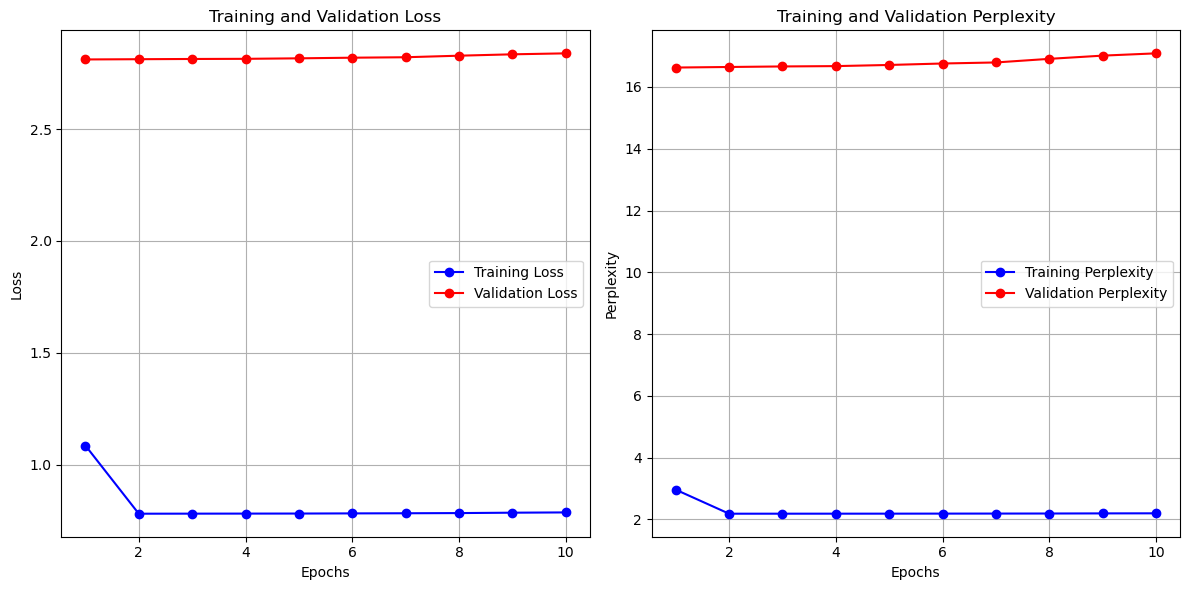

In [68]:
plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities)

### Example: Generating a Recipe with Optimized model

In [56]:
# # Load the best model
# best_model, tokenizer = load_model(best_model_path)
# tokenizer.pad_token = tokenizer.eos_token
# best_model.to(device)

OSError: Incorrect path_or_model_id: './models/best_gpt2_model_100'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [69]:
# Generate the recipe
recipe_text = generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, model_optim, tokenizer)

print(recipe_text)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


RuntimeError: 3'th index 1024 of condition tensor does not match the other tensors

### If best N epochs = 1, then train for 1 epoch to visualize the training process

In [54]:
# Train for 1 epoch to visualize the training process

def train_for_one_epoch(model, train_loader, val_loader, optimizer, device):
    model.train()
    total_train_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:  # Log every 10 batches
            print(f'Batch {batch_idx + 1}, Loss: {loss.item()}')

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    
    print('Training for 1 Epoch:')
    print(f'- Average Training Loss: {avg_train_loss}')
    print(f'- Validation Loss: {avg_val_loss}')

In [55]:
best_batch_size = int(best_params['batch_size'])
train_loader_1E, val_loader_1E = create_data_loaders(recipes, best_batch_size, tokenizer, max_length=512)

optimizer = torch.optim.AdamW(model_optim.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
train_for_one_epoch(model, train_loader_1E, val_loader_1E, optimizer, device)

Training for 1 Epoch:
- Average Training Loss: 6.456393718719482
- Validation Loss: 6.381645679473877


In [57]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk
import numpy as np

# Ensure that NLTK resources are downloaded
# nltk.download('punkt')

def calculate_bleu(references, hypotheses):
    """
    Calculate BLEU score between actual and predicted sentences.
    """
    smoothie = SmoothingFunction().method4
    return corpus_bleu([[ref.split()] for ref in references], [hyp.split() for hyp in hypotheses], smoothing_function=smoothie)


def evaluate_model(model, tokenizer, device, val_loader):
    """
    Evaluate the model on the validation set after one epoch of training.
    """
    model.eval()
    hypotheses = []
    references = []
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Generate text from input ids
            generated_ids = model.generate(input_ids, attention_mask=attention_mask)
            generated_text = [tokenizer.decode(g_id, skip_special_tokens=True) for g_id in generated_ids]
            actual_text = [tokenizer.decode(a_id, skip_special_tokens=True) for a_id in labels]
            
            hypotheses.extend(generated_text)
            references.extend(actual_text)

    # Calculate Perplexity 
    perplexity = np.exp(total_loss / len(val_loader))
    
    # Calculate BLEU score
    bleu_score = calculate_bleu(references, hypotheses)
    
    return {
        'perplexity': perplexity,
        'bleu': bleu_score,
    }


results = evaluate_model(best_model, tokenizer, device, val_loader_1E)
print(results)

[nltk_data] Downloading package punkt to /Users/nc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/Applications/anaconda3/envs/p2r/lib/python3.8/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 512, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


{'perplexity': 32.51880950736368, 'bleu': 1.0}


## Pre-trained GPT-2 Model

In [58]:
# Load the GPT-2 model and tokenizer
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model, tokenizer = load_model('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [59]:
batch_size = 4
train_loader, val_loader = create_data_loaders(recipes, batch_size, tokenizer, max_length=512)

training_losses, validation_losses, training_perplexities, validation_perplexities, model = train_and_validate(model, device, train_loader, val_loader)

Epoch 1/10 | Train Loss: 1.735 | Train PPL: 5.671 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 2/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 3/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 4/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 5/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 6/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 7/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 8/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 9/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899
Epoch 10/10 | Train Loss: 1.653 | Train PPL: 5.224 | Val Loss: 6.382 | Val PPL: 590.899


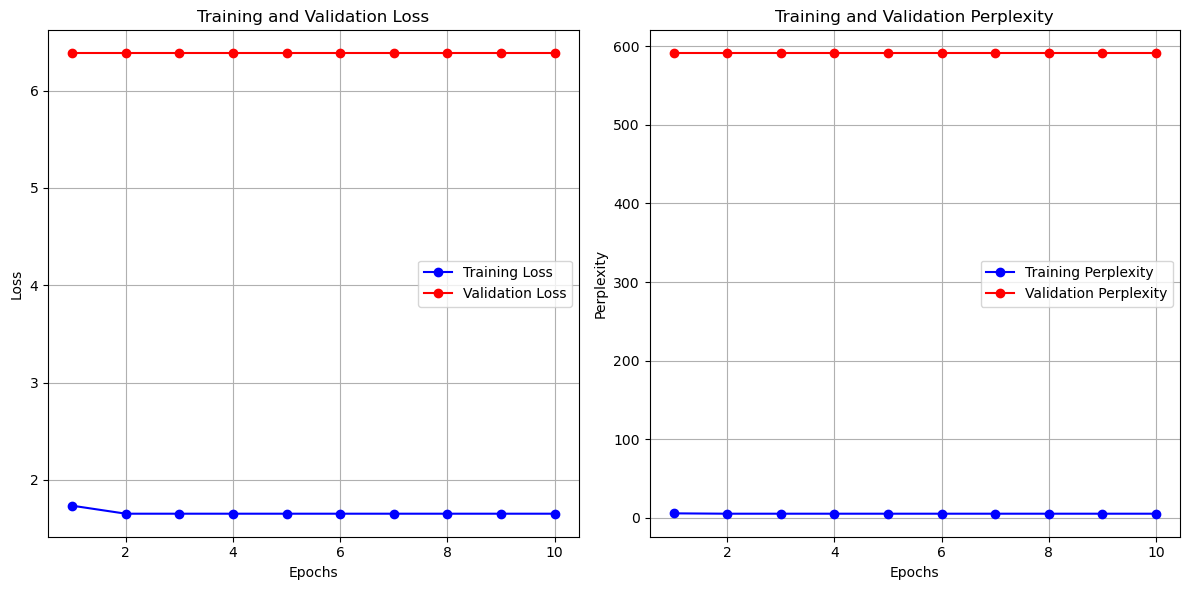

In [64]:
plot_validation_curves(training_losses, validation_losses, training_perplexities, validation_perplexities)

#### Example: Using pretrained GPT-2 with Cosine Similarity for Recipe Generation

In [65]:
tfidf_vectorizer, tfidf_matrix = prepare_similarity_matrix(recipes)

recipe_text = generate_recipe_text(user_ingredients, recipes, tfidf_vectorizer, tfidf_matrix, model, tokenizer)
print(recipe_text)

RuntimeError: 3'th index 1024 of condition tensor does not match the other tensors